#  HW1: Professionalism & Reproducibility

Regina-Mae Dominguez  
DATA 512: Human Centered Data Science    
University of Washington, MSDS - Autumn Quarter 2022


In [2]:
import json, time, urllib.parse, pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns

In [3]:
import requests

### Dataset

Import list of dinosaur articles that we would like to get pageviews for

In [4]:
dinosaurs = pd.read_csv("dinosaur_genera.cleaned.SEPT.2022.csv",  encoding='latin1')

In [5]:
# fix the parsing of one article with quotes in name
dinosaurs['name'][0] = "\"Coelosaurus\" antiquus"

In [6]:
dinosaurs.head()

,name,url
0,"""Coelosaurus"" antiquus",https://en.wikipedia.org/wiki/Coelosaurus_an...
1,Aachenosaurus,https://en.wikipedia.org/wiki/Aachenosaurus
2,Aardonyx,https://en.wikipedia.org/wiki/Aardonyx
3,Abdarainurus,https://en.wikipedia.org/wiki/Abdarainurus
4,Abditosaurus,https://en.wikipedia.org/wiki/Abditosaurus


### Setting up functions to pull data from Pageviews API

This portion utilizes the Pageviews API (https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews, https://wikimedia.org/api/rest_v1/#/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end) and sets up the API call. 

In [9]:
#########
#
#    CONSTANTS
#
###########

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens
REQUEST_HEADERS = {
    'User-Agent': '<rmvd@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# set the article titles to be the dinosaurs name column 
ARTICLE_TITLES = dinosaurs['name']

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",
    "end":         "2022100100"    # this is likely the wrong end date
}



In [10]:
#########
#
#    PROCEDURES/FUNCTIONS
#
#######

# specifically define what article title and type of access
def request_pageviews_per_article(article_title = None, 
                                  access_type = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    
    # Make sure we have an article title and directed access type
    if not article_title: return None
    if not access_type: return None
    
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    request_template['access'] = access_type
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



# Get Pageviews Data 

For each type of access, create an overall dictionary and append all article data into that dictionary.

### Monthly Desktop Counts

In [40]:
overall = {}

In [28]:
for article in ARTICLE_TITLES:
    view = request_pageviews_per_article(article, "desktop")
    view[article] = view['items']
    del view['items']
    overall.update(view)

In [ ]:
# save file to local drive
with open('dino_monthly_desktop_start201501_end202210.json', 'w') as outfile:
    json.dump(overall, outfile)

### Monthly Mobile-App Counts

In [48]:
overall_mobile_app = {}

In [49]:
for article in ARTICLE_TITLES:
    views_app = request_pageviews_per_article(article, "mobile-app")
    views_app[article] = views_app['items']
    del views_app['items']
    overall_mobile_app.update(views_app)

In [51]:
# save file to local drive
with open('mobile_app.json', 'w') as outfile:
    json.dump(overall_mobile_app, outfile)

### Monthly Mobile-Web Counts

In [53]:
overall_mobile_web = {}

In [55]:
for article in ARTICLE_TITLES:
    views_web = request_pageviews_per_article(article, "mobile-web")
    views_web[article] = views_web['items']
    del views_web['items']
    overall_mobile_web.update(views_web)

In [56]:
# save file to local drive
with open('mobile_web.json', 'w') as outfile:
    json.dump(overall_mobile_web, outfile)

## Sum Counts

The API separates mobile access into two different requests: mobile-app and mobile-web. We want to get the sum of their respective pageviews count to have an overall 'mobile' count. 

We also want to sum mobile and desktop views together.

In [201]:
# load in mobile json files to avoid rerunning API call again 
with open('mobile_app.json') as f:
    overall_mobile_app = json.load(f)
    
with open('mobile_web.json') as f:
    overall_mobile_web = json.load(f)

We will sum by transforming the json files into a dataframe first and matching the timestamps to the specific access and view counts. We will then return the sum into another json file.

In [208]:
# takes json files produced from API and converts them to dataframe
def to_dataframe(dict1):
    rows = []
    for k in dict1: 
        data_row = dict1[k]
        for row in data_row:
            rows.append(row)

    df = pd.DataFrame(rows)
    return(df)

# inputs:
# dict1 & dict2: dictionaries to sum views from 
# access1 & access2: what accesses to sum 
# col_name: desired column name for summed value

# output:
# dict_output: dictionary with summed values and article names as key
def sum_views(dict1, dict2, access1, access2, col_name):
    df1 = to_dataframe(dict1)
    df2 = to_dataframe(dict2)
    
    df1 = df1.append(df2)
    df = df1
    df = df.pivot_table(index=['project', 'article', 'granularity', 'timestamp', 'agent'], columns='access', values='views')
    df[col_name] = df[access1] + df[access2]
    df = df.reset_index()
    df = pd.melt(df, id_vars=['project', 'article', 'granularity', 'timestamp', 'agent'], value_vars=[col_name])
    df = df.rename(columns={"value": "views"})
    
    dict_output = {}
    for k in df.article.unique():
        dict_output[k] = {}
        subset = df[df['article'] == k]
        dict_output[k] = subset.to_dict('r')
        
    return(dict_output)
        
    

In [209]:
# get the sum of mobile-acess and mobile-web
overall_mobile = sum_views(overall_mobile_app, overall_mobile_web, 'mobile-app', 'mobile-web', 'mobile_access')

In [210]:
# save to local drive
with open('dino_monthly_mobile_start201501_end202210.json', 'w') as f:
    json.dump(overall_mobile, f)

### Sum Mobile & Desktop

In [206]:
# load in desktop json file to avoid rerunning API call again 
with open('json_data.json') as f:
    overall_desktop= json.load(f)

In [211]:
# sum desktop and mobile views by month
overall_views = sum_views(overall_mobile, overall_desktop, 'mobile_access', 'desktop', 'all')

In [212]:
with open('dino_monthly_cumulative_start201501_end202210.json', 'w') as f:
    json.dump(overall_views, f)

## Maximum Average and Minimum Average

We would like to graph the time series for the articles with the highest average page requests and lowest average page requests for desktop access and mobile access.


In [306]:
# convert these accesses to dataframes
df_mobile = to_dataframe(overall_mobile)
df_desktop = to_dataframe(overall_desktop)

In [307]:
# do not include 0 in computing the average
df_mobile_avg = df_mobile[df_mobile['views'] != 0]
df_desktop_avg = df_desktop[df_desktop['views'] !=0]

In [330]:
# average the views for each article and get the article
# with the lowest and highest average
# -- MOBILE ACCESS

df_mobile_avg = df_mobile_avg.groupby('article')['views'].agg('mean').reset_index()
df_mobile_avg_sort = df_mobile_avg.sort_values(by='views', ascending=False)
highest_article_mobile = df_mobile_avg_sort['article'].iloc[0]
lowest_article_mobile = df_mobile_avg_sort['article'].iloc[len(df_mobile_avg_sort)-1]
mobile_articles = [highest_article_mobile, lowest_article_mobile]

In [331]:
# average the views for each article and get the article
# with the lowest and highest average
# -- DESKTOP ACCESS

df_desktop_avg = df_desktop_avg.groupby('article')['views'].agg('mean').reset_index()
df_desktop_avg_sort = df_desktop_avg.sort_values(by='views', ascending=False)
highest_article_desktop = df_desktop_avg_sort['article'].iloc[0]
lowest_article_desktop = df_desktop_avg_sort['article'].iloc[len(df_desktop_avg_sort)-1]
desktop_articles = [highest_article_desktop, lowest_article_desktop]

In [339]:
# get the time series data for highest and lowest article
# -- DESKTOP

df_desktop_avg_min_max = df_desktop[df_desktop['article'].isin(desktop_articles)].copy()
title_highest_desktop = "Max Avg. Desktop: " + highest_article_desktop
title_min_desktop = "Min Avg. Desktop: " + lowest_article_desktop

df_desktop_avg_min_max['article'] = df_desktop_avg_min_max['article'].replace([highest_article_desktop], title_highest_desktop)
df_desktop_avg_min_max['article'] = df_desktop_avg_min_max['article'].replace([lowest_article_desktop], title_min_desktop)

,project,article,granularity,timestamp,access,agent,views
45172,en.wikipedia,Min Avg. Desktop: Honghesaurus,monthly,2015070100,desktop,user,23
45173,en.wikipedia,Min Avg. Desktop: Honghesaurus,monthly,2015080100,desktop,user,13
45174,en.wikipedia,Min Avg. Desktop: Honghesaurus,monthly,2015090100,desktop,user,27
45175,en.wikipedia,Min Avg. Desktop: Honghesaurus,monthly,2015100100,desktop,user,16
45176,en.wikipedia,Min Avg. Desktop: Honghesaurus,monthly,2015110100,desktop,user,10
...,...,...,...,...,...,...,...
103278,en.wikipedia,Max Avg. Desktop: Tyrannosaurus,monthly,2022050100,desktop,user,48438
103279,en.wikipedia,Max Avg. Desktop: Tyrannosaurus,monthly,2022060100,desktop,user,58017
103280,en.wikipedia,Max Avg. Desktop: Tyrannosaurus,monthly,2022070100,desktop,user,46505
103281,en.wikipedia,Max Avg. Desktop: Tyrannosaurus,monthly,2022080100,desktop,user,38432


In [342]:
# get the time series data for highest and lowest article
# -- MOBILE

df_mobile_avg_min_max = df_mobile[df_mobile['article'].isin(mobile_articles)].copy()
title_highest_mobile = "Max Avg. mobile: " + highest_article_mobile
title_min_mobile = "Min Avg. mobile: " + lowest_article_mobile

df_mobile_avg_min_max['article'] = df_mobile_avg_min_max['article'].replace([highest_article_mobile], title_highest_mobile)
df_mobile_avg_min_max['article'] = df_mobile_avg_min_max['article'].replace([lowest_article_mobile], title_min_mobile)

# combine time series for mobile and desktop
df_avg_all = df_desktop_avg_min_max.append(df_mobile_avg_min_max)

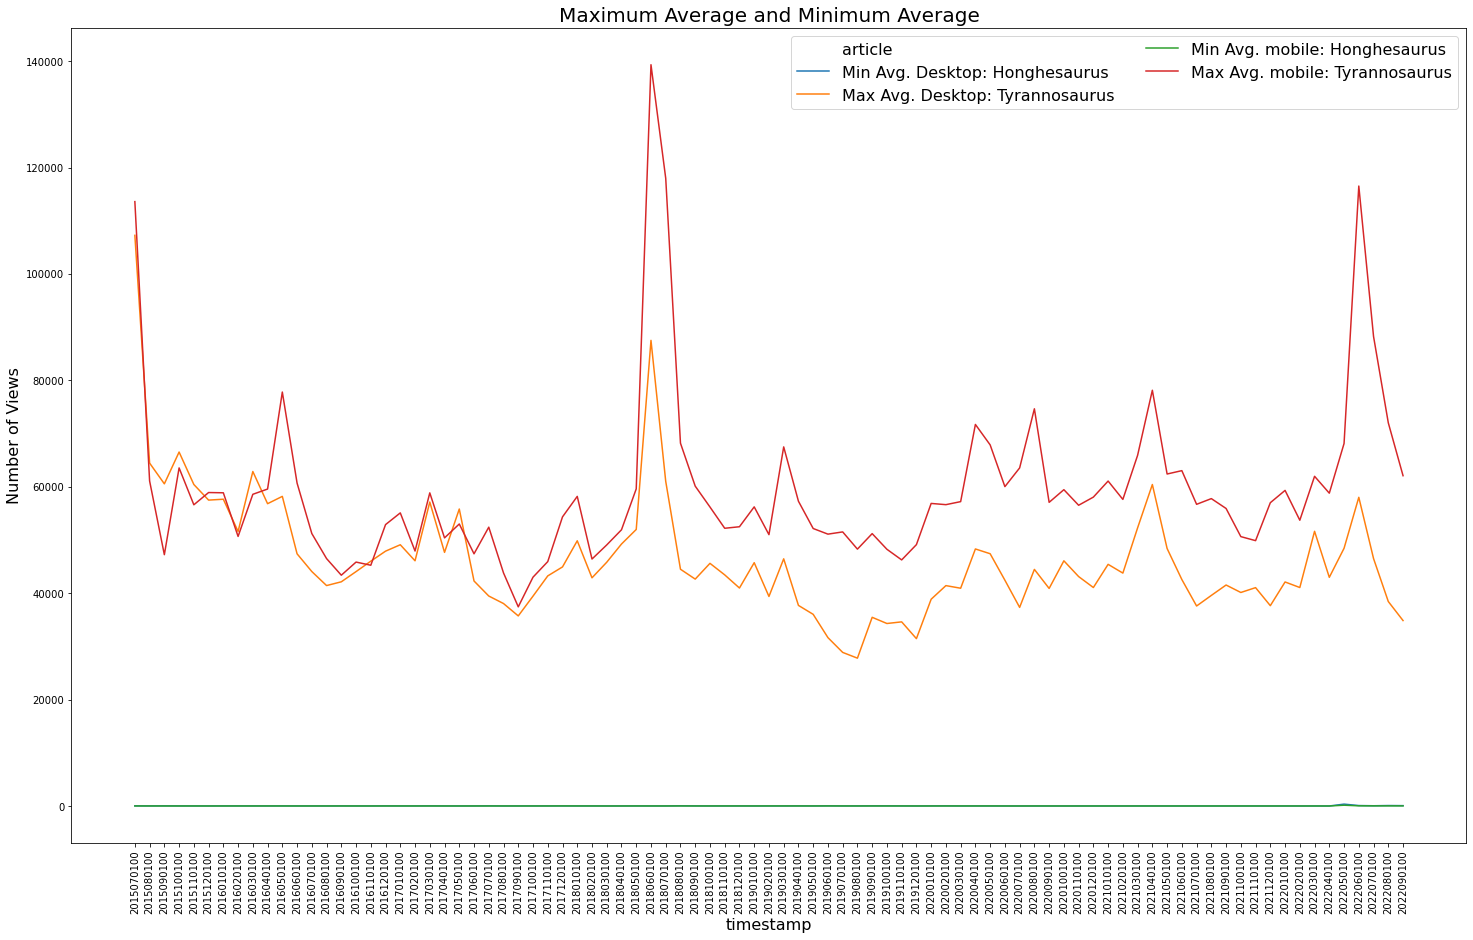

In [350]:
# PLOT TIME SERIES
fig = plt.figure(figsize=(25, 15))
ax = sns.lineplot(x='timestamp', y='views', hue='article', data=df_avg_all)
plt.xticks(rotation = 90)
plt.title('Maximum Average and Minimum Average', fontsize=20)
plt.xlabel('timestamp', fontsize=16)
plt.ylabel('Number of Views', fontsize=16)
plt.legend(fontsize=16, ncol=2)
plt.show()

fig.savefig('max_and_min_avg.png')

The articles with the minimum average and maximum average for both desktop and mobile were the same, max average: Tyrannosaurus and min average: Honghesaurus. This is more than likely due to the popularity of the Tyrannosaurus (possibly the most known dinosaur) and the unfamiliarity of Honghesaurus. However, you can see that the differences between the number of views is so vast with Honghesaurus being on the very lower end of values.

## Top 10 Peak Page Views

Here, we would like to see the time series for the top 10 article pages by largest (peak) views over the entire time by access type. We do so by getting the largest view count by each article and getting the top 10.

In [225]:
# find mobile top 10 peak
df_mobile_max_views = df_mobile.groupby('article')['views'].agg('max').reset_index()
df_mobile_max_views = df_mobile_max_views.sort_values(by='views', ascending=False)
top_10_mobile = df_mobile_max_views[0:10]
top_10_mobile_articles = top_10_mobile['article']

In [252]:
# finding desktop top 10 peak
df_desktop_max_views = df_desktop.groupby('article')['views'].agg('max').reset_index()
df_desktop_max_views = df_desktop_max_views.sort_values(by='views', ascending=False)
top_10_desktop = df_desktop_max_views[0:10]
top_10_desktop_articles = top_10_desktop['article']

In [267]:
# save only the top 10 data and rename for graph purposes
df_desktop_top_ten = df_desktop[df_desktop['article'].isin(top_10_desktop_articles)].copy()
df_desktop_top_ten['article'] = df_desktop_top_ten['article'].map('Desktop top 10: {}'. format)

df_mobile_top_ten = df_mobile[df_mobile['article'].isin(top_10_mobile_articles)].copy()
df_mobile_top_ten['article'] = df_mobile_top_ten['article'].map('Mobile top 10: {}'. format)

# append desktop and mobile
df_all = df_desktop_top_ten.append(df_mobile_top_ten)
df_all

,project,article,granularity,timestamp,access,agent,views
712,en.wikipedia,Desktop top 10: Achelousaurus,monthly,2015070100,desktop,user,1181
713,en.wikipedia,Desktop top 10: Achelousaurus,monthly,2015080100,desktop,user,703
714,en.wikipedia,Desktop top 10: Achelousaurus,monthly,2015090100,desktop,user,699
715,en.wikipedia,Desktop top 10: Achelousaurus,monthly,2015100100,desktop,user,708
716,en.wikipedia,Desktop top 10: Achelousaurus,monthly,2015110100,desktop,user,691
...,...,...,...,...,...,...,...
105168,en.wikipedia,Mobile top 10: Velociraptor,monthly,2022050100,mobile_access,user,45282
105169,en.wikipedia,Mobile top 10: Velociraptor,monthly,2022060100,mobile_access,user,75803
105170,en.wikipedia,Mobile top 10: Velociraptor,monthly,2022070100,mobile_access,user,46600
105171,en.wikipedia,Mobile top 10: Velociraptor,monthly,2022080100,mobile_access,user,34763


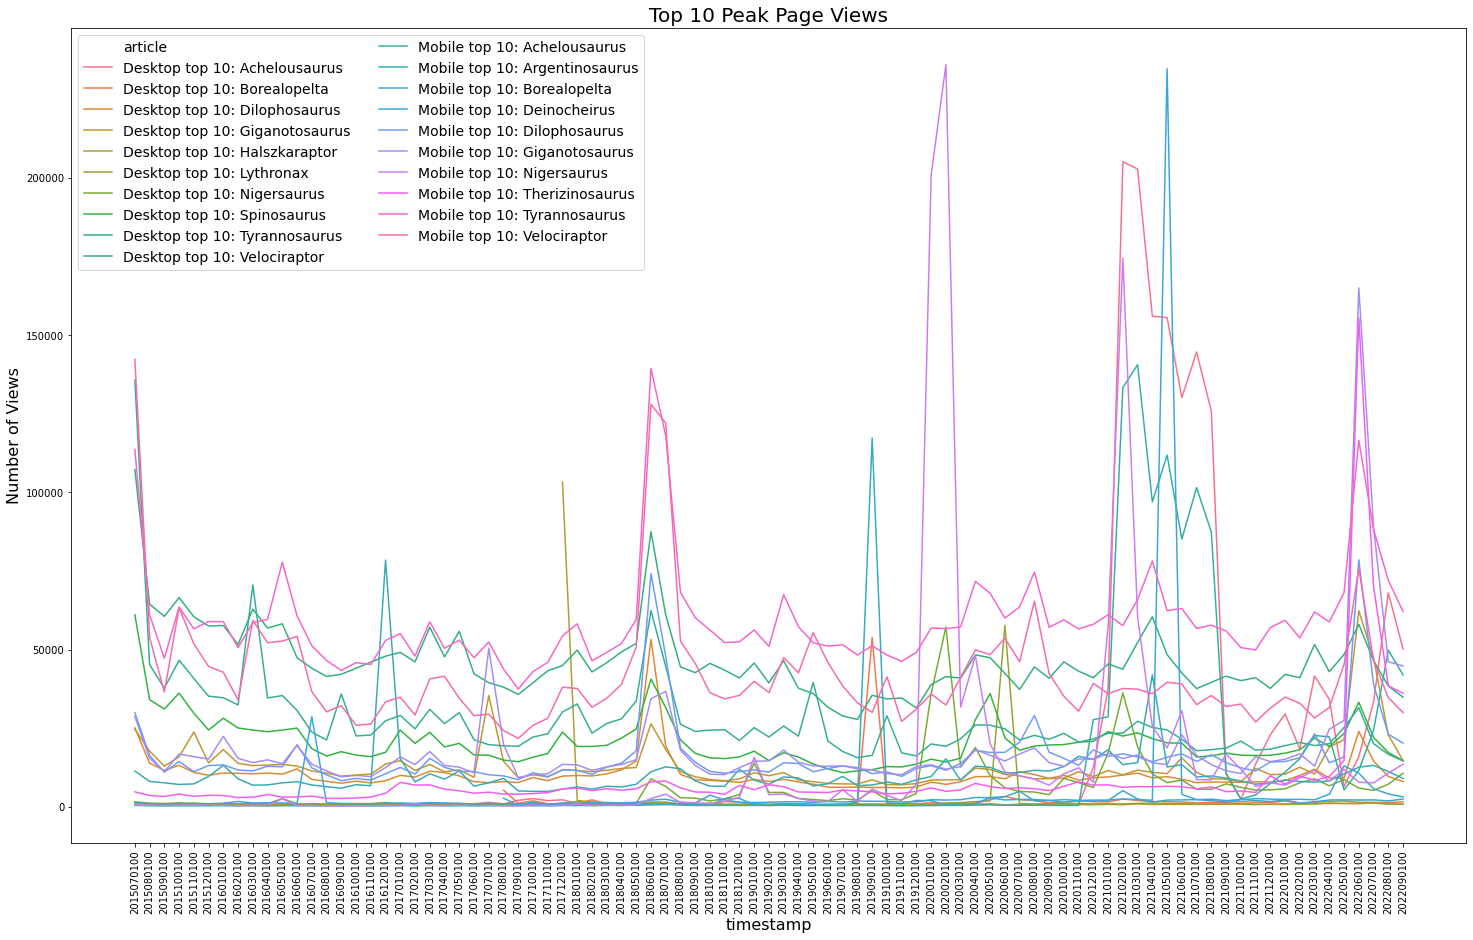

In [351]:
# PLOT TIME SERIES
fig = plt.figure(figsize=(25, 15))
ax = sns.lineplot(x='timestamp', y='views', hue='article', data=df_all)
plt.xticks(rotation = 90)
plt.title('Top 10 Peak Page Views', fontsize=20)
plt.xlabel('timestamp', fontsize=16)
plt.ylabel('Number of Views', fontsize=16)
plt.legend(fontsize=14, ncol=2)
plt.show()

fig.savefig('top_ten_page_peak_views.png')

What is interesting about the time series in this plot is that peaks in views for several articles occur around the same timestamp, i.e, it seems that most of the time series for these articles follow a similar trend. Could it be due to a possible Jurassic Park/World moving coming out in that time frame which reuslts in people looking up more dinosaurs, etc? 

## Fewest Months of Data

In this section, we want to show the time series for the articles that have the fewest months of avaliable data. We will count the number of rows for each article and plot the time series for last 10 articles with the least number of data for views.

In [292]:
# finding mobile fewest months of data
df_mobile_months = df_mobile.groupby('article')['views'].count().reset_index()
df_mobile_months = df_mobile_months.sort_values(by='views', ascending=True)
top_10_mobile_few_months = df_mobile_months[0:10]
top_10_mobile_few_months_articles = top_10_mobile_few_months['article']
top_10_mobile_few_months

,article,views
414,Elemgasem,1
1295,Tuebingosaurus,1
791,Mbiresaurus,2
209,Bisticeratops,2
617,Jakapil,2
966,Perijasaurus,2
615,Iyuku,3
938,Paralitherizinosaurus,5
403,Dzharaonyx,7
190,Bashanosaurus,7


In [293]:
# finding desktop fewest months of data
df_desktop_months = df_desktop.groupby('article')['views'].count().reset_index()
df_desktop_months = df_desktop_months.sort_values(by='views', ascending=True)
top_10_desktop_few_months = df_desktop_months[0:10]
top_10_desktop_few_months_articles = top_10_desktop_few_months['article']
top_10_desktop_few_months

,article,views
414,Elemgasem,1
1295,Tuebingosaurus,1
791,Mbiresaurus,2
209,Bisticeratops,2
617,Jakapil,2
966,Perijasaurus,2
615,Iyuku,3
938,Paralitherizinosaurus,5
403,Dzharaonyx,7
190,Bashanosaurus,7


In [297]:
#keep only articles with the fewest data points
df_desktop_top_ten_few_months = df_desktop[df_desktop['article'].isin(top_10_desktop_few_months_articles)].copy()
df_desktop_top_ten_few_months['article'] = df_desktop_top_ten_few_months['article'].map('Desktop top 10 few months: {}'. format)

df_mobile_top_ten_few_months = df_mobile[df_mobile['article'].isin(top_10_mobile_few_months_articles)].copy()
df_mobile_top_ten_few_months['article'] = df_mobile_top_ten_few_months['article'].map('Mobile top 10 few months: {}'. format)

# append mobile and desktop
df_all_few_month = df_desktop_top_ten_few_months.append(df_mobile_top_ten_few_months)

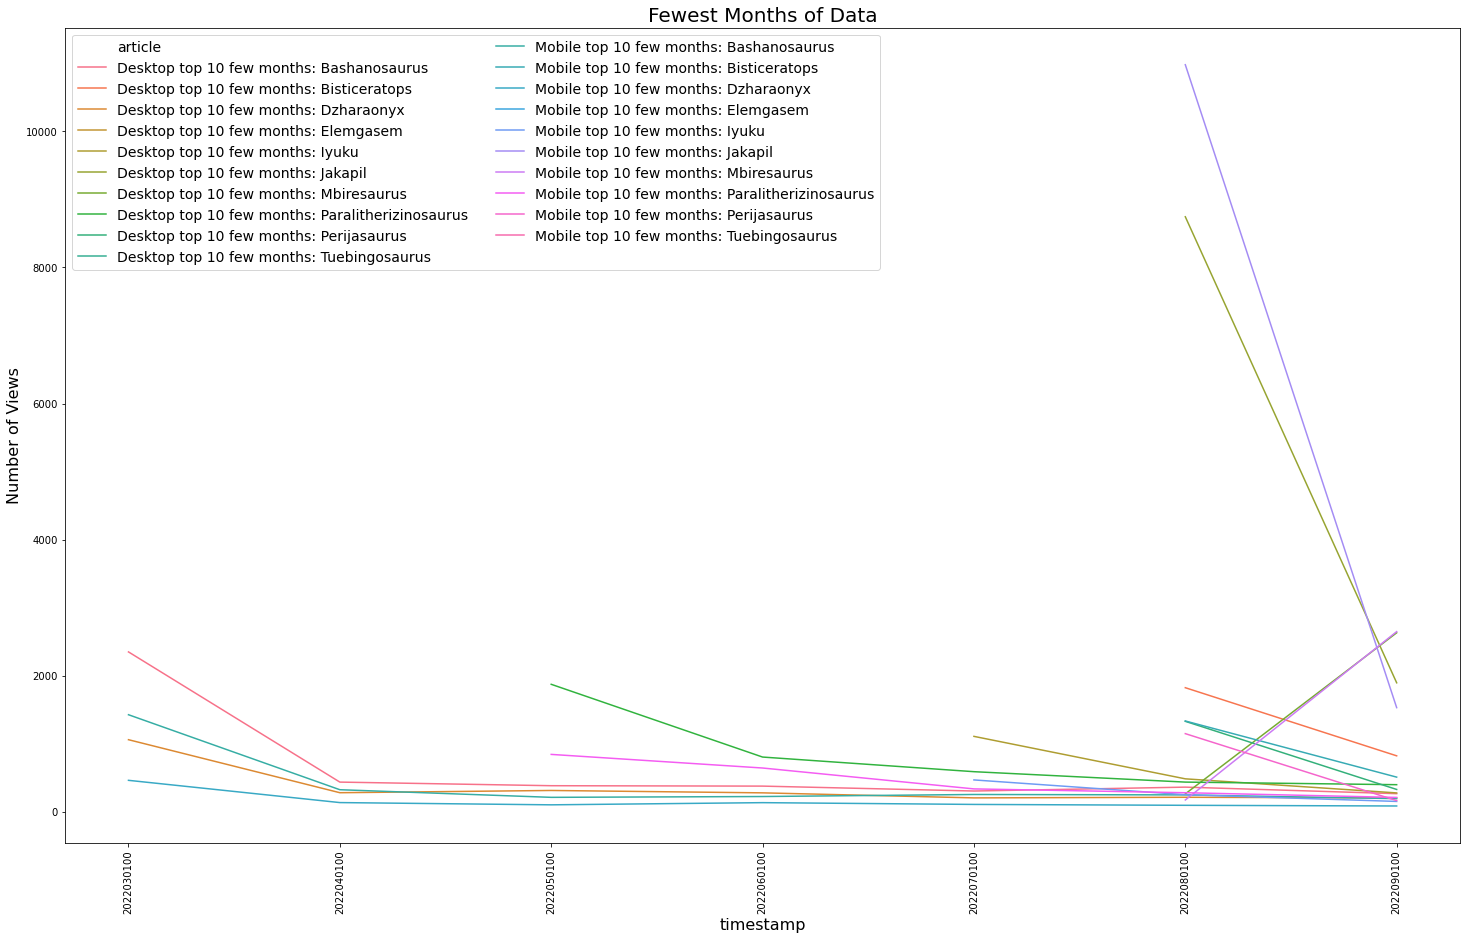

In [352]:
# PLOT TIME SERIES FOR THESE
fig = plt.figure(figsize=(25, 15))
ax = sns.lineplot(x='timestamp', y='views', hue='article', data=df_all_few_month)
plt.xticks(rotation = 90)
plt.title('Fewest Months of Data', fontsize=20)
plt.xlabel('timestamp', fontsize=16)
plt.ylabel('Number of Views', fontsize=16)
plt.legend(fontsize=14, ncol=2)
plt.show()

fig.savefig('fewest_months_of_data.png')

In this plot, we see the articles with the fewest amounts of data. WHat is interesting is that most of the articles are on the lower side of views. However, for some on reason, articles like "Jakapil", have a huge peak in views in one month (and no data in the months prior to this) and then decreases. Maybe, this article just got added to Wikipedia and became extremely popular with its page creation.